In [1]:
import numpy as np
from astropy.io import fits
from astropy import wcs
from matplotlib import rc 
from matplotlib import pyplot as plt
from matplotlib import colors
from spectral_cube import SpectralCube as sc
from astropy import units as u

rc("font", family="serif", size=10)
rc("axes", linewidth = 1)
rc("lines", linewidth = 1)
rc("xtick.major", pad = 5, width = 1)
rc("ytick.major", pad = 5, width = 1)
rc("xtick.minor", width = 1)
rc("ytick.minor", width = 1)
rc('ytick', direction='in', labelsize=10)
rc('xtick', direction='in', labelsize=10)
rc('axes', labelsize=15)
plt.rcParams.update({'axes.labelsize': 10})

In [2]:
hdu_cont = fits.open('./i10126_cont.fits')[0]
scu2 = sc.read('./i20126_hc3n.fits',hdu=0)

/Users/rzy/anaconda3/envs/py27/lib/python2.7/site-packages/spectral_cube/spectral_cube.py:2031: UserWarning: Cube is a Stokes cube, returning spectral cube for I component
  warnings.warn("Cube is a Stokes cube, "


In [3]:
# --------------------- data preparation -------------------
scu2 = scu2.with_spectral_unit(u.km / u.s, velocity_convention='radio')
_Tb_m = np.nan_to_num(scu2.hdu.data)

# ---------------reduce continuum dimension-----------------
cont_data = np.squeeze(hdu_cont.data)
cont_data = np.nan_to_num(cont_data)
_data1 = np.squeeze(hdu_cont.data)
_data1 = np.nan_to_num(_data1)
_w1 = wcs.WCS(hdu_cont, naxis=2)
hdu_cont2 = fits.ImageHDU(data=_data1, header=_w1.to_header())

Text(0.5,1,'HC3N')

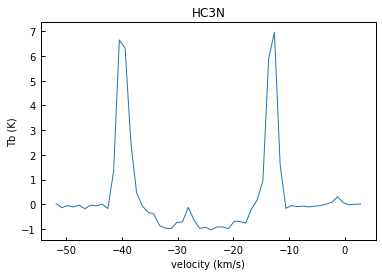

In [118]:
# ----------------- spectrum -----------------------
vsp = scu2.spectral_axis
（***************请补全后面的代码***************）

/Users/rzy/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


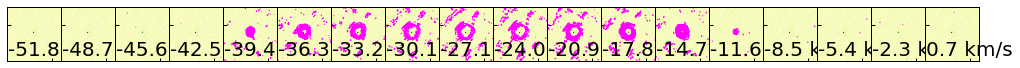

In [4]:
# ------------------------ channel map --------------------------
lvs = np.arange(0.1,1.4,0.4) * cont_data.max() * 0.9
max0 = np.max(_Tb_m)
vchan0 = scu2.spectral_axis.value

# ------------- parameters to edit --------------
x_width = 15  # plot board width
ny,nx = 2,20  # line and row number ************should edit*************
n1,dn = 0,18 
nstep = 3
# -----------------------------------------------

nsy,nsx = np.shape(_Tb_m[0,:,:])
ryx = (nsy*ny*1.0)/(nsx*nx*1.0)

%matplotlib inline
fig = plt.figure(1,figsize=(x_width,x_width*ryx)) # 
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.rc("font", family="Sans", size=10)

max0 = np.max(cont_data)
max1 = np.max(_Tb_m)
rms = np.std(_Tb_m[0,:,:])
lvs = np.arange(1,20,1)*4*rms

for i in np.arange(0,dn):
    ax1 = fig.add_subplot(ny,nx,i+1)
    Tb_chan = _Tb_m[i*nstep+n1,:,:]
    ax1.imshow(cont_data, cmap=plt.cm.YlGn, origin='lower')
    ax1.contour(Tb_chan, levels=lvs, colors='magenta',linewidths=1.0)
    ax1.axes.set_aspect('equal')
    ax1.text(5, 4, '%.1f'%vchan0[i*nstep+n1] +' km/s', \
         horizontalalignment='left',verticalalignment='bottom',fontsize=20)
    if i!=nx*(ny-1):
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    else:
        ax1.set_xlabel('RA (pixel)',fontsize=20)
        ax1.set_ylabel('Dec (pixel)',fontsize=20)

In [5]:
# ------------------------ reduce the noise data for moment maps -----------------------
_data = np.nan_to_num(scu2.hdu.data)
_w = wcs.WCS(scu2.hdu.header)
rms = np.std(_data[20,:,:])

idm = np.where(_data < rms*3) # bellow the noise level is set to zero.
_data[idm] = 0
scu2b = sc(data=_data, wcs=_w)
scu2b = scu2b.with_spectral_unit(u.km / u.s)
print(rms)

0.003995501


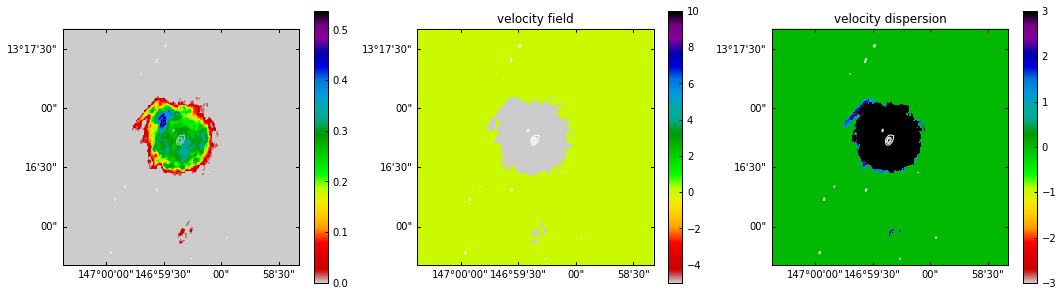

In [7]:
# --------------------------------moment map-------------------------------
hdu_in = hdu_cont2
scu_in = scu2b

fg1 = plt.figure(1, figsize=(18,5))
lvs = np.arange(0.1,0.9,0.3) * hdu_in.data.max()

ax1 = fg1.add_subplot(1,3,1, projection=wcs.WCS(hdu_in.header,naxis=2))
scu2_mi = scu_in.moment(order=0)  # moment0: integrated intensity
scu2_mi = scu2_mi.hdu.data
min0,max0 = np.min(scu2_mi), np.max(scu2_mi)
im1 = ax1.imshow(scu2_mi, cmap=plt.cm.nipy_spectral_r, vmin=min0, vmax=max0, origin='lower')
ax1.axes.set_aspect('equal')
ax1.contour(hdu_in.data, levels=lvs, linewidths=0.5, colors='white')
plt.colorbar(im1)

ax1 = fg1.add_subplot(1,3,2, projection=wcs.WCS(hdu_in.header,naxis=2))
scu2_mi = scu_in.moment(order=1)  # moment1: velocity field
scu2_mi = np.nan_to_num(scu2_mi.hdu.data)
min0,max0 = np.min(scu2_mi), np.max(scu2_mi)
im1 = ax1.imshow(scu2_mi, cmap=plt.cm.nipy_spectral_r, vmin=-5, vmax=10, origin='lower')  # edit
ax1.contour(hdu_in.data, levels=lvs, linewidths=1.0, colors='white')
ax1.axes.set_aspect('equal')
ax1.set_title('velocity field')
plt.colorbar(im1)

ax1 = fg1.add_subplot(1,3,3, projection=wcs.WCS(hdu_in.header,naxis=2))
scu2_mi = scu_in.moment(order=2) # moment2: velocity dispersion
scu2_mi = np.abs(np.nan_to_num(scu2_mi.hdu.data))
scu2_mi = np.sqrt(scu2_mi)
min0,max0 = np.min(scu2_mi), np.max(scu2_mi)
im1 = ax1.imshow(scu2_mi, cmap=plt.cm.nipy_spectral_r, vmin=-3, vmax=3, origin='lower') # edit
ax1.contour(hdu_in.data, levels=lvs, linewidths=1.0, colors='white')
ax1.axes.set_aspect('equal')
ax1.set_title('velocity dispersion')
plt.colorbar(im1)

In [119]:
dir(colors)

['BASE_COLORS',
 'BoundaryNorm',
 'CSS4_COLORS',
 'ColorConverter',
 'Colormap',
 'LightSource',
 'LinearSegmentedColormap',
 'ListedColormap',
 'LogNorm',
 'NoNorm',
 'Normalize',
 'PowerNorm',
 'Sized',
 'SymLogNorm',
 'TABLEAU_COLORS',
 'XKCD_COLORS',
 '_ColorMapping',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 '_colors_full_map',
 '_is_nth_color',
 '_sanitize_extrema',
 '_to_rgba_no_colorcycle',
 '_vector_dot',
 '_vector_magnitude',
 'absolute_import',
 'cbook',
 'cnames',
 'colorConverter',
 'division',
 'from_levels_and_colors',
 'get_named_colors_mapping',
 'hex2color',
 'hexColorPattern',
 'hsv_to_rgb',
 'is_color_like',
 'itertools',
 'makeMappingArray',
 'np',
 'print_function',
 're',
 'rgb2hex',
 'rgb_to_hsv',
 'same_color',
 'six',
 'to_hex',
 'to_rgb',
 'to_rgba',
 'to_rgba_array',
 'unicode_literals',
 'warnings',
 'zip']

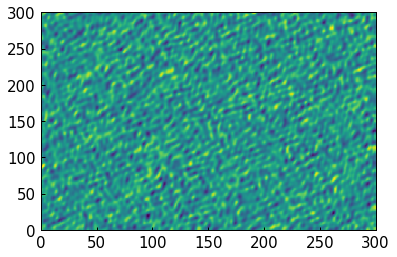

In [45]:
plt.pcolor(Tb_chan)

In [ ]:
Tb0 = np.sum(_Tb_m,axis=(1,2))
Tb0 = np.sum(_Tb_m[:,150:160,150:160],axis=(1,2))
plt.plot(vsp,Tb0)
plt.xlabel('velocity (km/s)')
plt.ylabel('Tb (K)')
plt.title('HC3N')